In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset, \
    StockPricesDataset, get_prices_features, normalize_features,\
    generate_sentiment_features

from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

In [162]:
prices_df = yf.download(
    tickers= "MSFT",
    start="2020-01-01",
    end="2022-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [163]:
prices_df.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', name='Date', length=755, freq=None)

In [173]:
sentiment = generate_sentiment_features(
    "MSFT",
    updated= True
)

In [174]:
sentiment.index = pd.to_datetime(sentiment.index)

In [194]:
scaler = MinMaxScaler(feature_range=(0.,0.25))
normalized = scaler.fit_transform(prices_df[["Close"]])

# normalized_sentiment = scaler.fit_transform(
#     sentiment[["sentiment_count"]]
# )
normalized_sentiment = sentiment

In [195]:
normalized_prices = pd.Series(
    normalized.reshape(-1),
    index = prices_df.index    
)

# normalized_sentiment = pd.Series(
#     normalized_sentiment.reshape(-1),
#     index= sentiment.index
# )

In [196]:
index = normalized_prices\
    .index\
    .intersection(normalized_sentiment.index)

In [197]:
normalized_prices = normalized_prices\
    .reindex(index = index)

normalized_sentiment = normalized_sentiment\
    .reindex(
        index = index
    )

In [198]:
normalized_sentiment

,sentiment_count
2020-05-19,1.000000
2020-05-27,0.000000
2020-08-03,1.000000
2020-09-28,0.000000
2020-09-29,0.000000
...,...
2022-12-22,0.333333
2022-12-23,0.384615
2022-12-27,0.000000
2022-12-28,-0.250000


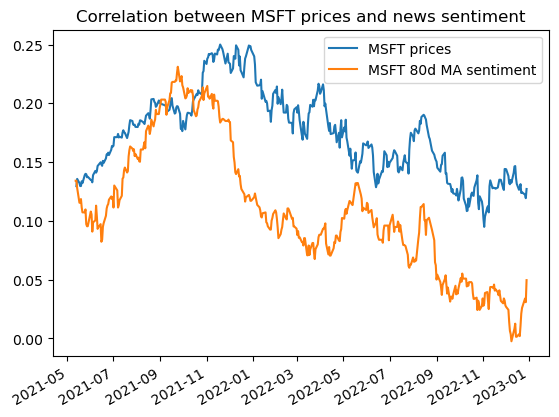

In [201]:
normalized_prices.iloc[80:].plot(
    label = "MSFT prices"
)

normalized_sentiment\
    .sentiment_count\
    .rolling(80)\
    .mean()\
    .plot(
        label = "MSFT 80d MA sentiment"
    )

plt.title("Correlation between MSFT prices and news sentiment")
plt.legend()

plt.savefig("img/correlation_msft.png", bbox_inches = "tight")

In [200]:
normalized_sentiment\
    .sentiment_count\
    .rolling(80)\
    .mean()\
    .corr(normalized_prices)
    

0.6839789062219696